A time series is a set of data points ordered in time

Ideally, the data is equally spaced in time(every hour, every minute, etc.)

Examples: 
- Closing value of stock
- Household's electricity consumption
- Temperature outside

In [1]:
!pip install utilsforecast


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("daily_sales_french_bakery.csv",parse_dates=["ds"]) #treat ds column as date and time
df = df.groupby('unique_id').filter(lambda x:len(x)>=28)
df = df.drop(columns=['unit_price'])
df.head()



,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


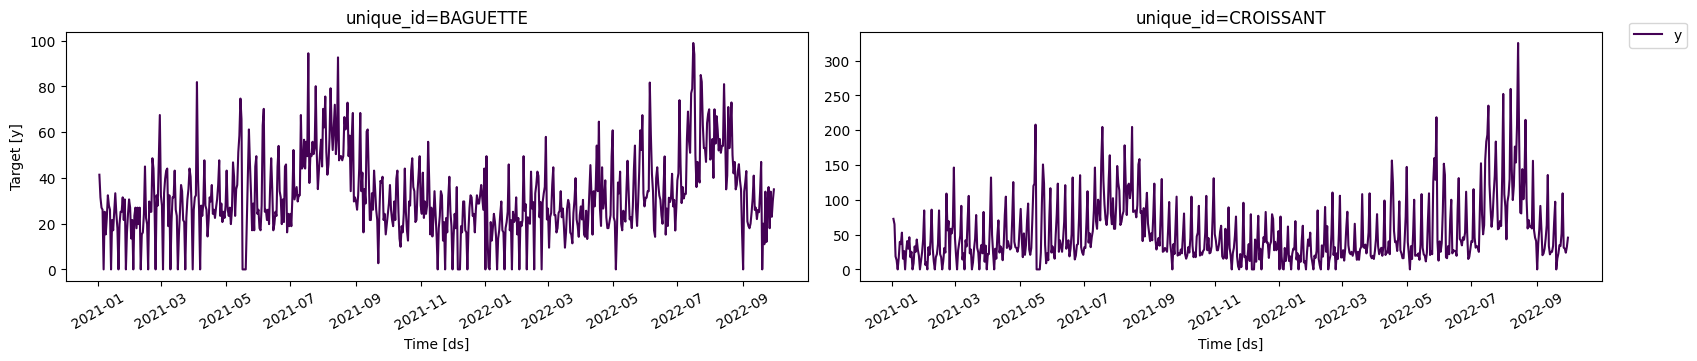

In [4]:
plot_series(df=df, ids=["BAGUETTE","CROISSANT"],palette="viridis")

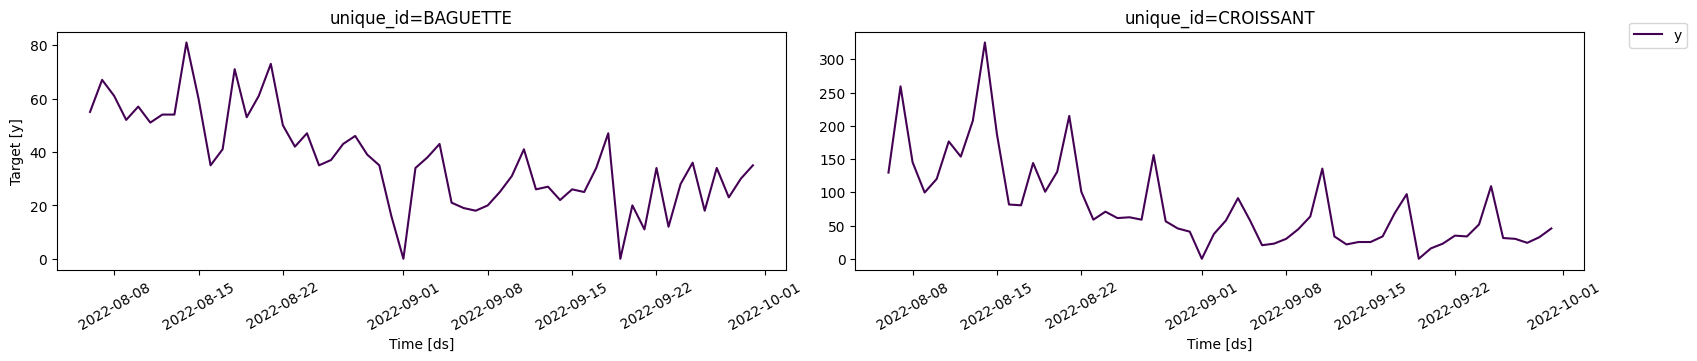

In [5]:
plot_series(df=df, ids=["BAGUETTE","CROISSANT"],max_insample_length=56,palette="viridis")

In [6]:
from statsforecast import StatsForecast
from statsforecast.models import Naive,HistoricAverage,WindowAverage,SeasonalNaive


Naive - forecast is simply the last observed value

Historic Average - forecast is the average of all past values

Window Average - The forecast is the average of the most recent k values

Seasonal Naive - The foorecast repeast the value from the same season in the past(eg. data is daily and seasonality =7, then todays forecast = what happened 7 days ago)

In [7]:
horizon = 7
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models = models, freq="D")#object responsible for training, fitting ,pred, cross valid etc..
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [8]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


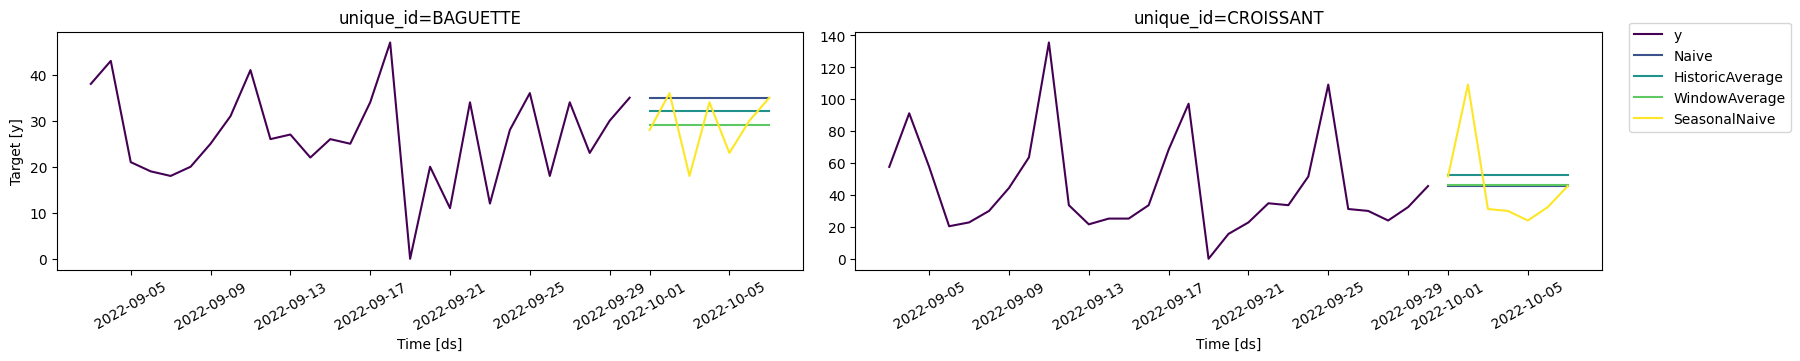

In [9]:
plot_series(
    df=df,
    forecasts_df = preds,
    ids=["BAGUETTE","CROISSANT"],
    max_insample_length=28,
    palette="viridis")


Evaluate baseline models


In [15]:
test = df.groupby("unique_id").tail(7) #last 7 days
train = df.drop(test.index).reset_index(drop=True) #rest is training data

In [16]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test,preds,
                   'left',['ds','unique_id'])


In [17]:
evaluation = evaluate(
    eval_df,
    metrics =[mae], #mean abs error -> avg of the abs dist bw the predns and the actual dist and avg of it
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [18]:
evaluation = evaluation.drop(['unique_id'],axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


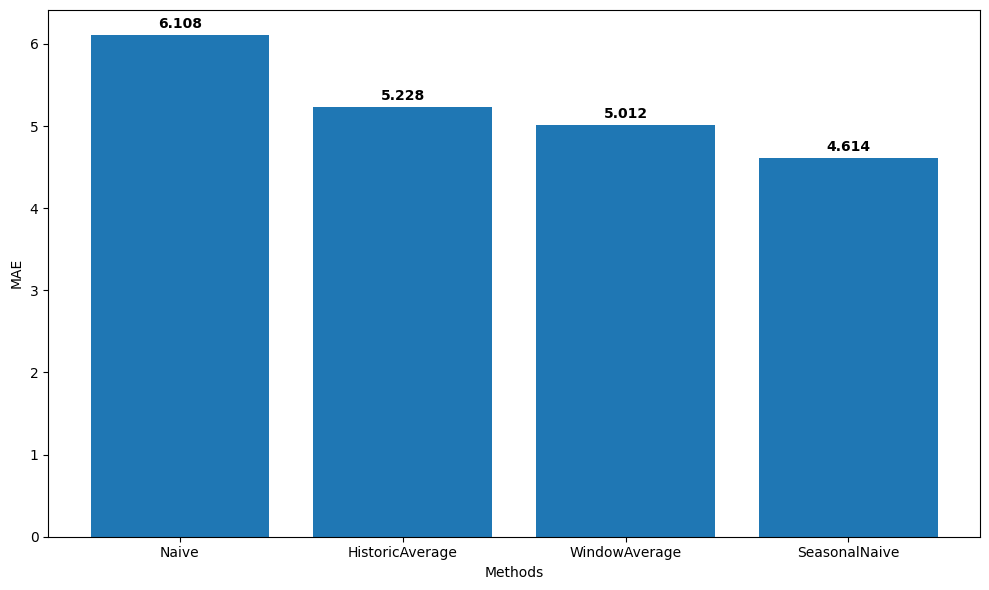

In [21]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0,1:].tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(methods,values)

for bar,value in zip(bars,values):
    plt.text(bar.get_x() + bar.get_width()/2,bar.get_height()+0.05,
             f'{value:.3f}',ha='center',va='bottom',fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

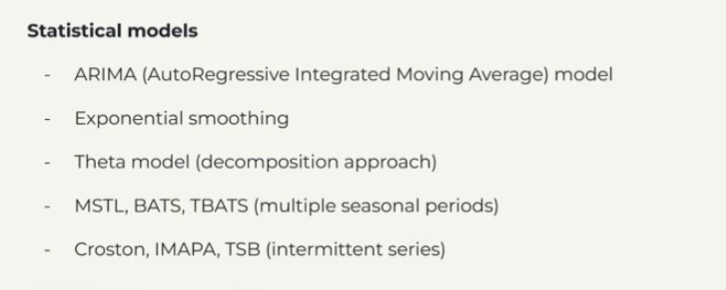
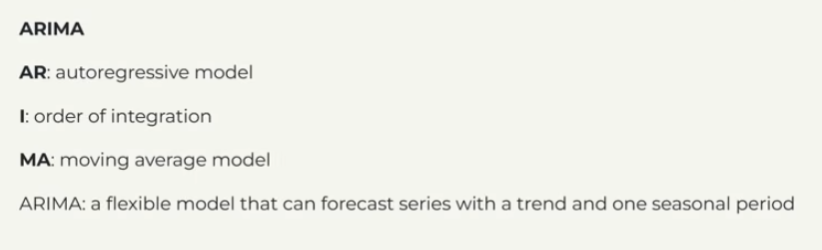
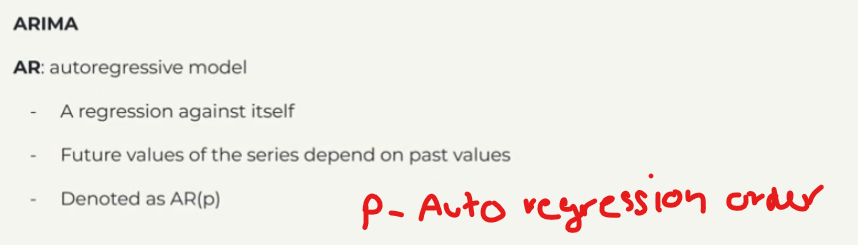
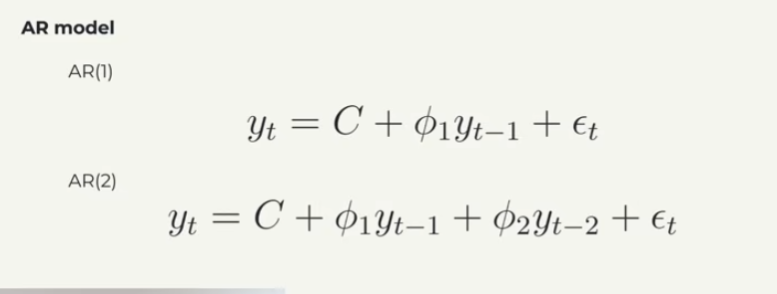
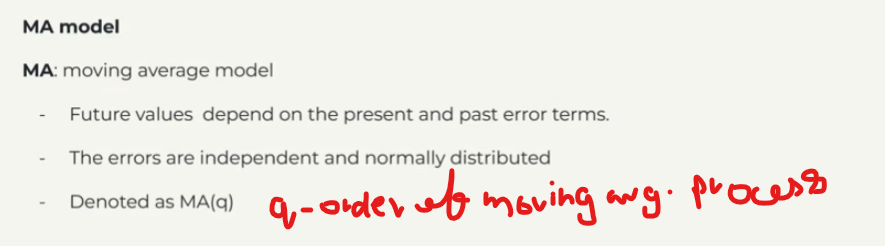
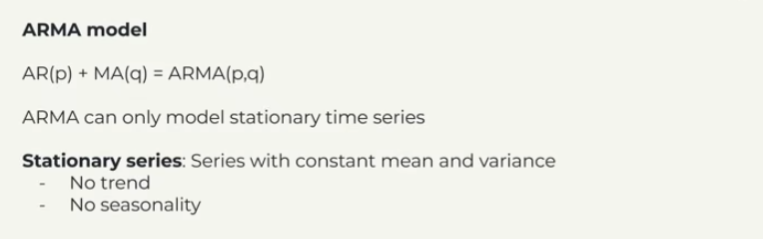
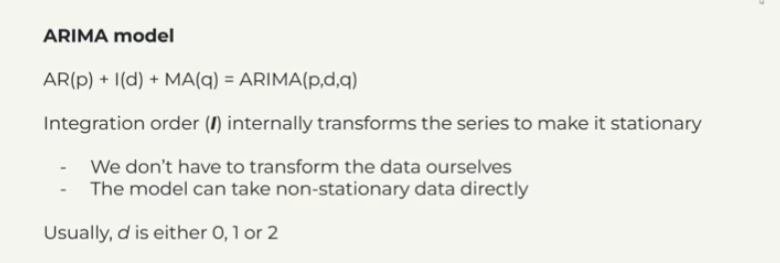
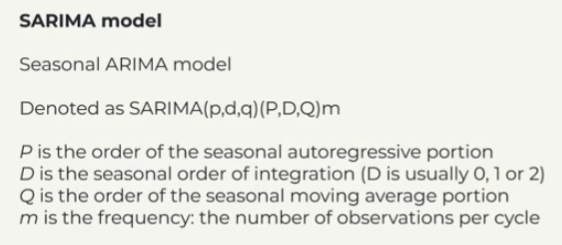
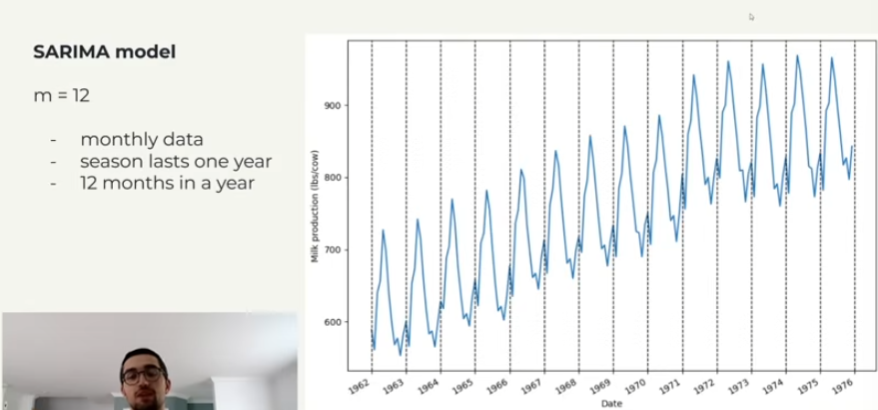
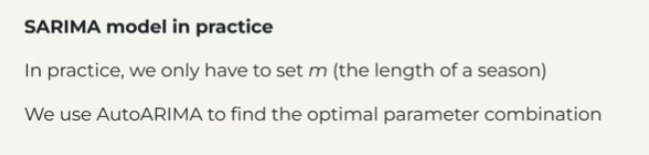


AutoARIMA

In [ ]:
from statsforecast.models import AutoARIMA